# Sunitha Nagrath Lab [Title] #

In [1]:
# necesary installs

!pip install pandas numpy tensorflow scikit-learn matplotlib seaborn

# 1. Data Filtering

In [2]:
## necesarry imports ##

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [3]:
## open csv files ##

image_number_table = pd.read_csv("MyExpt_Image_Number_w_file.csv")
qc_table = pd.read_csv("MyExpt_FilteredCells_with_Cell_Quality_annotation.csv")

## Filter out B and E

In [4]:
## filter bad images ##

valid_images = image_number_table[image_number_table['Quality'] == 'G'].set_index('ImageNumber')

# debug
print(valid_images['Quality'])
print(valid_images[valid_images['Quality'] != 'G'].size == 0)

ImageNumber
8      G
9      G
10     G
11     G
12     G
      ..
267    G
268    G
269    G
270    G
271    G
Name: Quality, Length: 128, dtype: object
True


In [5]:
## merge with QC_table ##

valid_images = pd.merge(valid_images, qc_table, on='ImageNumber', how='left')
print(valid_images.shape)
print(valid_images.iloc[:10, :8])

(5922, 127)
   ImageNumber           FileName_DAPI           FileName_FITC  \
0            8  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif   
1            8  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif   
2            8  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif   
3            8  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif   
4            8  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif   
5            8  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif   
6            8  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif   
7            8  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif   
8            8  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif   
9            8  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif   

             FileName_RFP Quality  ObjectNumber Quality only bad  \
0  Export_B11_0007_C3.tif       G             1                P   
1  Export_B11_0007_C3.tif       G             2                P   
2  Export_B11_0007_C3.tif       G             3          

## Model **1**: Logistic Regression With Rows 76-79

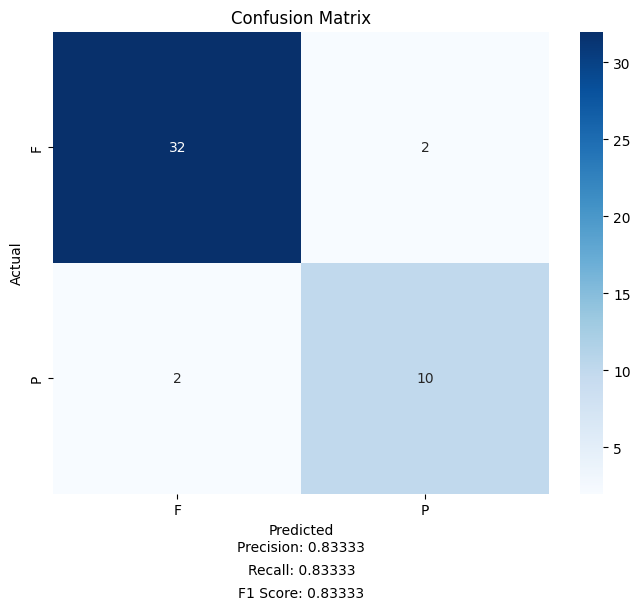

In [6]:
## train a logistic model to determine P (poor quality pictures) ##

### models could be updated to be using a more complex and accurate anomaly detection algorithm if needed ###

## model 1: uses only images 76-79

# train data using labeled data set (images 76 - 79)
train_start = 76
train_end = 79
labeled_data = valid_images[
    (valid_images['ImageNumber'] >= train_start) & 
    (valid_images['ImageNumber'] <= train_end)
]

# convert scientific notations to numeric values
labeled_data.iloc[:, 7:] = labeled_data.iloc[:, 7:].apply(pd.to_numeric, errors='coerce')

# X = features, y = target
X = labeled_data.iloc[:, 7:].values # features
y = labeled_data['Quality only bad'].values  # target

# deal with empty columns (logistic regression does not take NaN values)
nan_columns = np.any(np.isnan(X), axis=0)
nan_indices = np.where(nan_columns)[0]
columns_to_delete = [nan_indices]
X = np.delete(X, columns_to_delete, axis=1)

# assign value for binary ('P' and one other)
y = pd.Series(y)
y.fillna('F', inplace=True) # F for fine quality (vs. poor quality)

# split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# train logistic model
model1 = LogisticRegression()
model1.fit(X_train, y_train)

# predict
y_pred = model1.predict(X_test)

# compute confusion matrix using y_test (true labels for test set) and y_pred
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['F', 'P'], yticklabels=['F', 'P'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
# metrics
precision = precision_score(y_test, y_pred, pos_label='P')
recall = recall_score(y_test, y_pred, pos_label='P')
f1 = f1_score(y_test, y_pred, pos_label='P') # f1 score is reliable for unbalanced data sets like this one
# add metrics to the confusion matrix png
plt.text(0.5, -0.1, f"Precision: {precision:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.15, f"Recall: {recall:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.2, f"F1 Score: {f1:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
# Save the confusion matrix to a file
plt.savefig("Metrics/M1_confusion_matrix.png", format='png',bbox_inches='tight')
plt.show()

## Model **2**: Logistic Regression With All Labeled Images

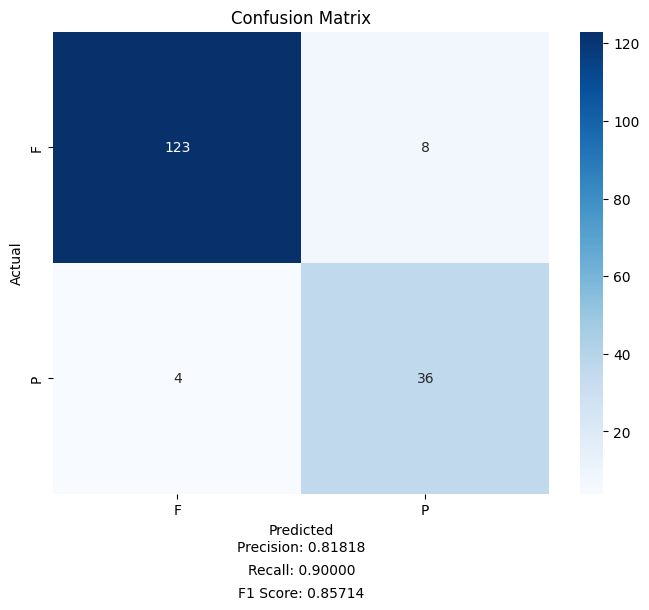

In [52]:
## model 2: uses all images that has 'quality only bad' filled

def train_and_evaluate_logistic_regression(X, y, params=None):
    # Split test and train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train logistic model with custom parameters
    model = LogisticRegression(**params) if params else LogisticRegression()
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['F', 'P'], yticklabels=['F', 'P'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')

    # Metrics
    precision = precision_score(y_test, y_pred, pos_label='P')
    recall = recall_score(y_test, y_pred, pos_label='P')
    f1 = f1_score(y_test, y_pred, pos_label='P')

    # Add metrics to the confusion matrix plot
    plt.text(0.5, -0.1, f"Precision: {precision:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
    plt.text(0.5, -0.15, f"Recall: {recall:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
    plt.text(0.5, -0.2, f"F1 Score: {f1:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

    # Save the confusion matrix to a file
    plt.savefig("Metrics/M2_confusion_matrix.png", format='png', bbox_inches='tight')
    plt.show()
    plt.close()  # Close the figure to free memory

    return model, precision, recall, f1

# Model 2: uses all images that have 'quality only bad' filled
image_filled = valid_images.groupby('ImageNumber')['Quality only bad'].apply(lambda x: (x == 'P').sum())
labeled_data = valid_images[valid_images['ImageNumber'].isin(image_filled[image_filled > 0].index)]

# Convert scientific notations to numeric values
labeled_data.iloc[:, 7:] = labeled_data.iloc[:, 7:].apply(pd.to_numeric, errors='coerce')

# X = features, y = target
X = labeled_data.iloc[:, 7:].values  # features
y = labeled_data['Quality only bad'].values  # target

# Deal with empty columns (logistic regression does not take NaN values)
nan_columns = np.any(np.isnan(X), axis=0)
nan_indices = np.where(nan_columns)[0]
X = np.delete(X, nan_indices, axis=1)

# Assign value for binary ('P' and one other)
y = pd.Series(y)
y.fillna('F', inplace=True)  # F for fine quality (vs. poor quality)

# Example usage with custom parameters
custom_params = {
    'C': 1.0,                # Inverse of regularization strength
    'penalty': 'l2',         # 'l2' for Ridge
    'solver': 'lbfgs',       # Algorithm to use
    'max_iter': 200          # Maximum number of iterations
}

model2, precision, recall, f1 = train_and_evaluate_logistic_regression(X, y, params=custom_params)

## Model **3**: One-Class SVM with Non-Linear RBF Kernel

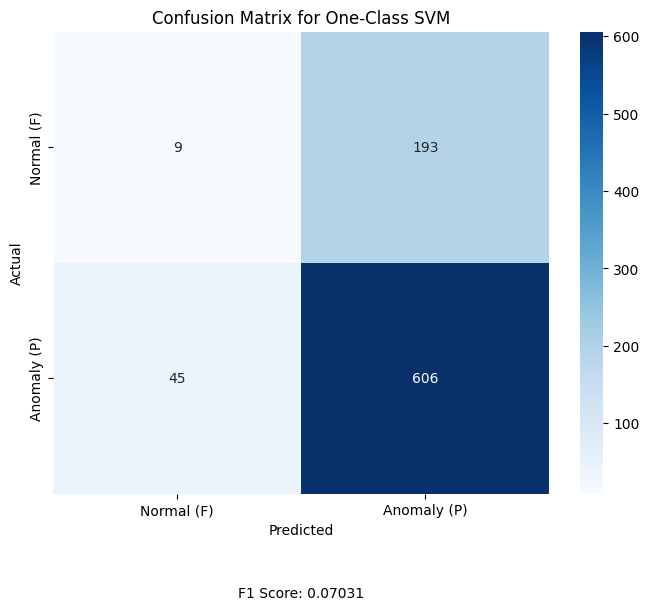

202 853
Predictions for labeled data: [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1  1  1  1 -1  1  1 -1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1 -1  1  1 -1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1 

In [50]:
# One-class svm
# Pros:
#     1. Works well with high-dementional data sets (datasets that has many X features)
#     2. can do half-supervised learning
# Cons: complex, so only works with small enough data sets (10,000 rows and 70 cols should be fine)

# Retrieve labeled data
p_count = valid_images.groupby('ImageNumber')['Quality only bad'].apply(lambda x: (x == 'P').sum())
labeled_indices = valid_images[valid_images['ImageNumber'].isin(p_count[p_count > 0].index)].index

# Separate labeled and unlabeled data
labeled_data = valid_images.loc[labeled_indices]
unlabeled_data = valid_images.drop(labeled_indices)

# Prepare features, omit empty columns
nan_columns = valid_images.iloc[:, 7:].isna().any()
columns_to_delete = valid_images.columns[7:][nan_columns].tolist()
X_labeled = labeled_data.iloc[:, 7:].drop(columns=columns_to_delete)
X_unlabeled = unlabeled_data.iloc[:, 7:].drop(columns=columns_to_delete)

# Convert scientific notations to numbers
X_labeled = X_labeled.apply(pd.to_numeric, errors='coerce')
X_unlabeled = X_unlabeled.apply(pd.to_numeric, errors='coerce')

# Standardize the data
scaler = StandardScaler()
X_labeled_scaled = scaler.fit_transform(X_labeled)
X_unlabeled_scaled = scaler.transform(X_unlabeled)

# Instantiate the One-Class SVM
model3 = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)

# Fit the model on the labeled data
model3.fit(X_labeled_scaled)

# Make predictions for both labeled and unlabeled data
predictions_labeled = model3.predict(X_labeled_scaled)  # 1 for normal, -1 for anomaly
predictions_unlabeled = model3.predict(X_unlabeled_scaled)

# Combine predictions
predictions = np.full(len(valid_images), 1)  # Initialize as normal (1)
predictions[labeled_indices] = predictions_labeled
predictions[unlabeled_data.index] = predictions_unlabeled

# Prepare true labels for evaluation: Convert 'P' to -1 (anomaly) and 'F' to 1 (normal)
true_labels = np.where(labeled_data['Quality only bad'] == 'P', -1, 1)

# Calculate confusion matrix for the labeled data only
conf_matrix = confusion_matrix(true_labels, predictions[labeled_indices])

# Calculate f1-score
f1 = f1_score(true_labels, predictions[labeled_indices], pos_label=-1)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal (F)', 'Anomaly (P)'], 
            yticklabels=['Normal (F)', 'Anomaly (P)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for One-Class SVM')

# Save confusion matrix
plt.savefig("Metrics/M3_confusion_matrix.png", format='png', bbox_inches='tight')
plt.text(0.5, -0.2, f"F1 Score: {f1:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.show()

p_count = np.sum(predictions[labeled_indices] == -1)
p_count = np.sum(true_labels == -1)
total_count = np.count_nonzero(true_labels)
print(p_count, total_count)

# Debugging
print("Predictions for labeled data:", predictions[labeled_indices])
print("True labels for labeled data:", true_labels)

# Check lengths
print("Length of true_labels:", len(true_labels))
print("Length of predictions for labeled data:", len(predictions[labeled_indices]))

# Unique values
print("Unique values in predictions:", np.unique(predictions[labeled_indices]))
print("Unique values in true_labels:", np.unique(true_labels))

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(true_labels, predictions[labeled_indices]))

## Predict all P

In [ ]:
## apply model to the unlabeled rows and filter out P ##


#### model 2 had slightly better f1 score, so use model 2

unlabeled_data = valid_images

# convert scientific notations to numeric values
unlabeled_data.iloc[:, 7:] = unlabeled_data.iloc[:, 7:].apply(pd.to_numeric, errors='coerce')

# X = features
X_unlabeled = unlabeled_data.iloc[:, 7:].values

# impute missing values in features
X_unlabeled = imputer.transform(X_unlabeled)

# scale the features
X_unlabeled = scaler.transform(X_unlabeled)

# predict
predictions = model2.predict(X_unlabeled)

valid_images.loc[:, 'Quality only bad'] = predictions

# debug
print("number of Ps predicted: ", predictions[predictions == 'P'].size)
print("number of Ps actualy predicted:\n", valid_images[valid_images['Quality only bad'] == 'P']['Quality only bad'])

## Filter out P

In [ ]:
valid_cells = valid_images[valid_images['Quality only bad'] != 'P']

# debug
print(valid_cells['Quality only bad'])
print(valid_cells[valid_cells['Quality only bad'] == 'P'].size == 0)

### Code by: Yuru Chen, Touma Yoneyama